# 袋から取り出す問題でベイズ推定
- 観測結果から袋の選好（どの袋を好んで選んでいるか）推定したい
- 各袋の中身は、袋１：白玉１、赤玉９、袋２：白玉３、赤玉３、袋３：白玉９、赤玉１とする
- 袋を選ぶ人は実は袋１だけをやたら選ぶ人だとして、観測結果からそれを推定してみよう
- 重みつき乱数選択には、Walker's Alias Methodという効率の良い方法があります。興味があれば調べてみてください
- 今回の手法は非常にナイーブな方法ですので実用的ではありません

In [1]:
# 真の選好（袋１だけ妙に好き）これを推定したい
#true_p_b = [1/3,1/3,1-2/3]
true_p_b = [0.7,0.2,0.1]

In [2]:
#事前確率（各袋を選ぶ確率、観測する前の思い込み）
p_b = [1/3,1/3,1-2/3]

In [3]:
#条件付き確率(各袋で白玉が出る確率)
p_c1_bs = [0.1,0.5,0.9] #袋１で白玉が出る確率・・・

In [4]:
import random
import numpy as np

class SimpleChoiceByWeight():
    def __init__(self, weights):
        self.weights = np.array(weights)
        self.weight_sum = sum(weights)
        self.weights = self.weights / self.weight_sum

    def choice(self):
        r = random.random()

        num = 0
        for i, weight in enumerate(self.weights):
            num += weight
            if r <= num:
                return i

In [5]:
# 10回ばかり袋を選び、玉を取り出してみる

In [6]:
bg_sel = SimpleChoiceByWeight(true_p_b) #袋の選択

def ball_sampling():
    # 袋を選んで、玉を取り出す
    bag_id = bg_sel.choice()
    p_c1_b = p_c1_bs[bag_id]
    r = random.random()
    if r < p_c1_b:
        return '白玉'
    else:
        return '赤玉'  

In [7]:
results = []
for i in range(10000):
    res = ball_sampling()
    results.append(res)

In [8]:
import pandas as pd
df = pd.DataFrame(results)

In [9]:
df

,0
0,白玉
1,赤玉
2,赤玉
3,赤玉
4,赤玉
...,...
9995,赤玉
9996,白玉
9997,赤玉
9998,白玉


In [10]:
results.count("赤玉")

7344

In [11]:
df.describe()

,0
count,10000
unique,2
top,赤玉
freq,7344


## 観測結果をもとにベイズ推定してみる
- $P(袋|観測された玉の色)=\frac{P(観測された玉の色|袋)P(袋)}{P(観測された玉の色)} \propto P(観測された玉の色|袋)P(袋)$

In [12]:
def bayesest(d,p_b):
    p_b_posteriors = np.zeros(shape=len(p_b))
    for i, p_b_i in enumerate(p_b):
        # P(観測された玉の色|袋)
        if d == "白玉":
            p_c_b = p_c1_bs[i]
        else:
            p_c_b = 1 - p_c1_bs[i]
            
        # P(観測された玉の色|袋)P(袋)
        p_b_data = p_c_b * p_b_i
        p_b_posteriors[i] = p_b_data
      
    return p_b_posteriors/sum(p_b_posteriors)

In [13]:
p_c1_bs

[0.1, 0.5, 0.9]

In [14]:
print(p_b)

[0.3333333333333333, 0.3333333333333333, 0.33333333333333337]


In [15]:
cossims = []
new_p_b = p_b
for i, res in enumerate(results):
    new_p_b = bayesest(res, new_p_b)
#    print(new_p_b)
    cos = np.dot(new_p_b, true_p_b)
    cossims.append(cos)

In [16]:
new_p_b

array([1.00000000e+00, 5.53418965e-19, 0.00000000e+00])

In [17]:
true_p_b

[0.7, 0.2, 0.1]

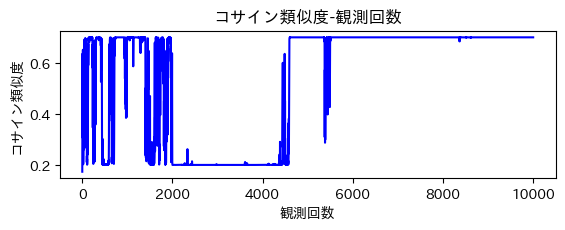

In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib


x = range(1,len(cossims)+1,1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.5)
#fig.suptitle("all graph")

ax1 = fig.add_subplot(211, title="コサイン類似度-観測回数",xlabel="観測回数", ylabel="コサイン類似度")
ax1.plot(x, cossims, 'b-')

fig.show()


- 逐次更新のやり方は始めは良いが、毎回入ってくる新しいデータを重視しすぎてしまい、うまくいかない
- 観測データ全体を使って、更新する方が良い

### バッチベイズ推定（データ全体を一括で推定）

In [19]:
def batch_bayes_estimate(d, p_b, p_c1_bs):
    n_white = d.count("白玉")
    n_red = len(d) - n_white
    p_b_posterior = np.zeros(len(p_b))
    for i in range(len(p_b)):
        # 各袋の尤度を計算
        loglikelihood = (np.log(p_c1_bs[i]) * n_white) + (np.log(1 - p_c1_bs[i]) * n_red)
        # 尤度x事前確率 =>事後確率
        p_b_posterior[i] = np.exp(loglikelihood + np.log(p_b[i]))

    # 正規化
    return p_b_posterior / p_b_posterior.sum()

In [20]:
# 結果を確認
new_p_b = batch_bayes_estimate(res, p_b, p_c1_bs)
print("推定結果:", new_p_b)
print("真の値:", true_p_b)

推定結果: [0.75700935 0.23364486 0.00934579]
真の値: [0.7, 0.2, 0.1]


# アソシエーション分析

In [21]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth


dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

#frequent_itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
### alternatively:
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
#frequent_itemsets = fpmax(df, min_support=0.6, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.8,(Eggs)
1,1.0,(Kidney Beans)
2,0.6,(Milk)
3,0.6,(Onion)
4,0.6,(Yogurt)
5,0.8,"(Kidney Beans, Eggs)"
6,0.6,"(Eggs, Onion)"
7,0.6,"(Milk, Kidney Beans)"
8,0.6,"(Kidney Beans, Onion)"
9,0.6,"(Yogurt, Kidney Beans)"


In [22]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Eggs),(Onion),0.8,0.6,0.6,0.75,1.25,1.0,0.12,1.6,1.0,0.75,0.375,0.875
1,(Onion),(Eggs),0.6,0.8,0.6,1.00,1.25,1.0,0.12,inf,0.5,0.75,1.000,0.875
2,"(Eggs, Kidney Beans)",(Onion),0.8,0.6,0.6,0.75,1.25,1.0,0.12,1.6,1.0,0.75,0.375,0.875
3,"(Kidney Beans, Onion)",(Eggs),0.6,0.8,0.6,1.00,1.25,1.0,0.12,inf,0.5,0.75,1.000,0.875
4,(Eggs),"(Kidney Beans, Onion)",0.8,0.6,0.6,0.75,1.25,1.0,0.12,1.6,1.0,0.75,0.375,0.875
5,(Onion),"(Eggs, Kidney Beans)",0.6,0.8,0.6,1.00,1.25,1.0,0.12,inf,0.5,0.75,1.000,0.875


# 共役事前分布（ベータ分布の例）

## 二項分布

<BarContainer object of 100 artists>

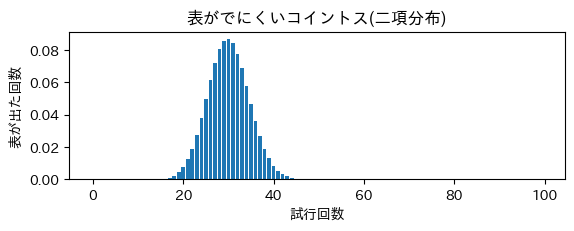

In [30]:
from scipy.stats import binom
import matplotlib.pyplot as plt

## 計算
n = 100  #試行回数
mu = 0.3 #成功確率
x = range(n)    #x軸
f = binom(n, mu) #確率分布
y = f.pmf(x)    #y軸


fig = plt.figure()
fig.subplots_adjust(hspace=0.5)
#fig.suptitle("all graph")
ax1 = fig.add_subplot(211, title="表がでにくいコイントス(二項分布)",xlabel="試行回数", ylabel="表が出た回数")
ax1.bar(x, y)

## ベータ分布（表が出る確率p(\mu)を決定する確率分布）

<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:11: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_72339/478844126.py:11: DeprecationWarning: invalid escape sequence '\m'
  ax1 = fig.add_subplot(211, title=f"ベータ分布 a={a},b={b}",xlabel="$\mu$", ylabel="$p(\mu)$")
/tmp/ipykernel_72339/478844126.py:11: DeprecationWarning: invalid escape sequence '\m'
  ax1 = fig.add_subplot(211, title=f"ベータ分布 a={a},b={b}",xlabel="$\mu$", ylabel="$p(\mu)$")


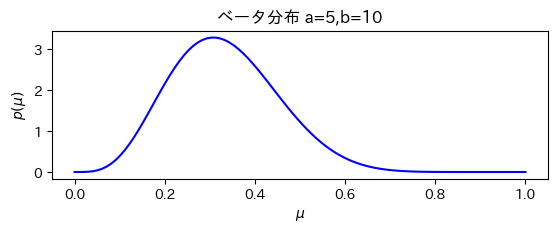

In [40]:
from scipy.stats import beta

a = 5
b = 10
x = np.linspace(0, 1, 100) #x軸
y = beta.pdf(x, a, b)      #y軸

fig = plt.figure()
fig.subplots_adjust(hspace=0.5)
#fig.suptitle("all graph")
ax1 = fig.add_subplot(211, title=f"ベータ分布 a={a},b={b}",xlabel="$\mu$", ylabel="$p(\mu)$")
ax1.plot(x, y, 'b-')

## 事後分布を計算 100回試行して30回表が出たとしよう

<>:14: DeprecationWarning: invalid escape sequence '\m'
<>:14: DeprecationWarning: invalid escape sequence '\m'
<>:14: DeprecationWarning: invalid escape sequence '\m'
<>:14: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_72339/2635418699.py:14: DeprecationWarning: invalid escape sequence '\m'
  ax1 = fig.add_subplot(211, title=f"事後ベータ分布 a={new_a},b={new_b}",xlabel="$\mu$", ylabel="$p(\mu)$")
/tmp/ipykernel_72339/2635418699.py:14: DeprecationWarning: invalid escape sequence '\m'
  ax1 = fig.add_subplot(211, title=f"事後ベータ分布 a={new_a},b={new_b}",xlabel="$\mu$", ylabel="$p(\mu)$")


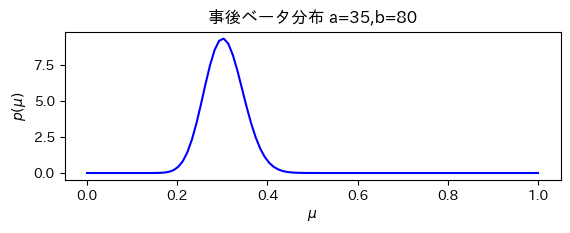

In [42]:
from scipy.stats import beta

N=100
m=30

new_a = m + a
new_b = N - m + b
x = np.linspace(0, 1, 100) #x軸
y = beta.pdf(x, new_a, new_b)      #y軸

fig = plt.figure()
fig.subplots_adjust(hspace=0.5)
#fig.suptitle("all graph")
ax1 = fig.add_subplot(211, title=f"事後ベータ分布 a={new_a},b={new_b}",xlabel="$\mu$", ylabel="$p(\mu)$")
ax1.plot(x, y, 'b-')